Generating 300 training samples...
Finding a smart initial guess for the optimizer...
Initial global lambdas found: [1.1059e+02 5.0000e-02 1.4000e-01 1.2000e-01]

Starting main emulator training...


/Users/rishabh/Desktop/Sem 7/APL871/Report_2022AM11793/venv/lib/python3.13/site-packages/scipy/optimize/_minimize.py:779: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 1459.695790
         Iterations: 30
         Function evaluations: 2733
         Gradient evaluations: 109
Training complete.

--- Validation ---

--- Moment Comparison ---
             Analytical      Emulated       
Mean         105.1271        99.7540        
Variance     451.0288        529.7805       


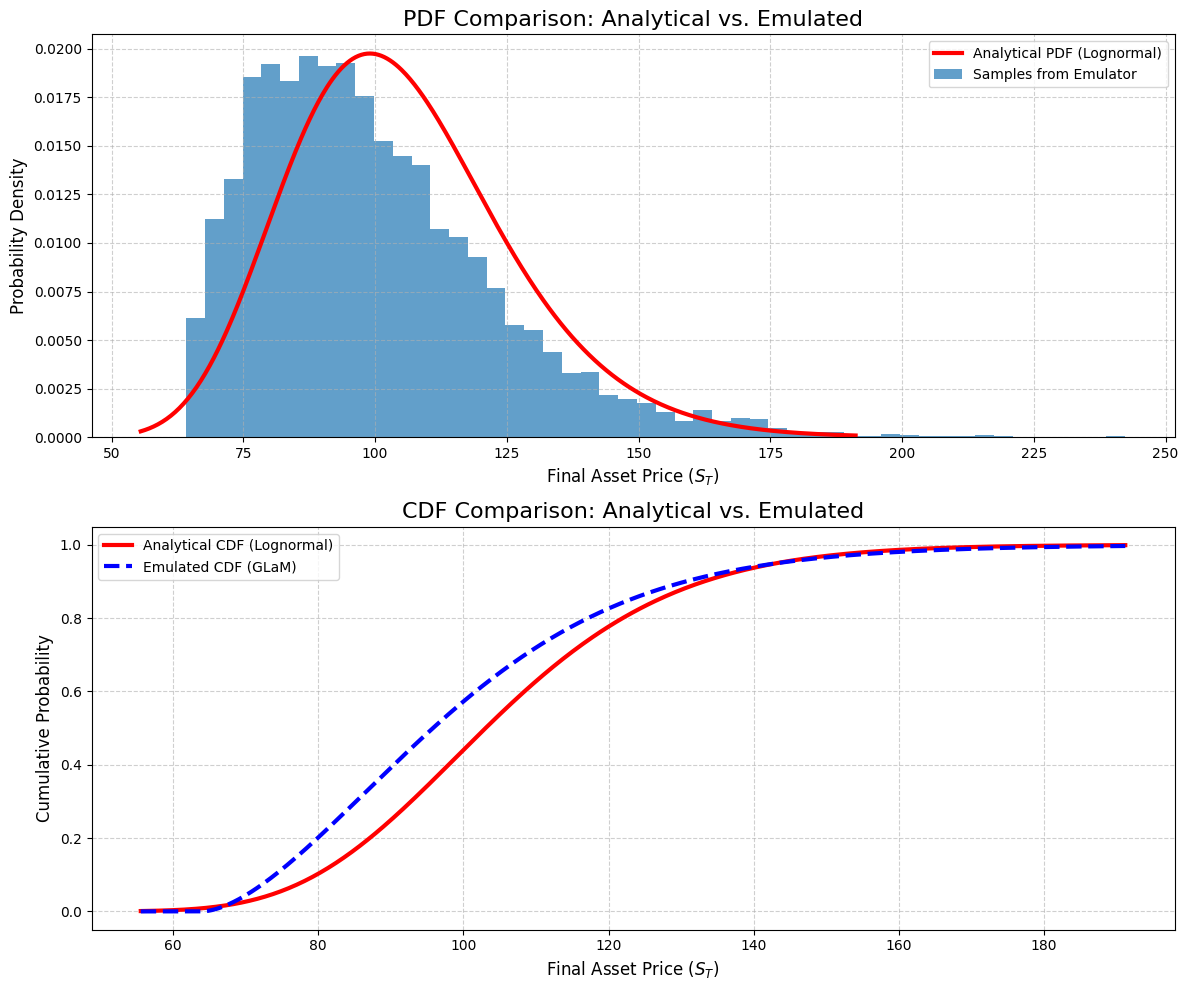

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, kstest, moment
from scipy.optimize import minimize, root_scalar
from scipy.special import comb
from sklearn.preprocessing import StandardScaler

# --- Step 1: Define Constants and Benchmark Parameters ---
S0 = 100.0  # Initial asset price
T = 1.0     # Time horizon (1 year)
DT = 0.01   # Time step for simulation

# --- Step 2: Implement the Stochastic Simulator (GBM) ---

def simulate_gbm(s0, mu, sigma, t, dt):
    """Simulates a single path of Geometric Brownian Motion."""
    n_steps = int(t / dt)
    s_t = s0
    for _ in range(n_steps):
        dW = np.random.normal(0.0, np.sqrt(dt))
        s_t += mu * s_t * dt + sigma * s_t * dW
    return s_t

# --- Analytical Solution for Validation ---

def get_analytical_distribution(s0, mu, sigma, t):
    """Returns the analytical lognormal distribution for GBM at time T."""
    mean_log = np.log(s0) + (mu - 0.5 * sigma**2) * t
    sigma_log = sigma * np.sqrt(t)
    return lognorm(s=sigma_log, scale=np.exp(mean_log))

# --- Step 3: Implement the GLaM Emulator ---

class GLaMEmulator:
    """A Generalized Lambda Model (GLaM) emulator."""
    def __init__(self, input_dim, poly_degree):
        self.input_dim = input_dim
        self.poly_degree = poly_degree
        self.num_coeffs = int(comb(poly_degree + input_dim, input_dim))
        self.total_coeffs = 4 * self.num_coeffs
        self.coeffs = None # Will be set during fitting
        self.scaler = StandardScaler()

    # --- NEW: Smart Initialization Method ---
    def _get_initial_coeffs(self, y_train):
        """
        Creates a smart initial guess for the coefficients by fitting a single
        GLD to the entire training output distribution.
        """
        print("Finding a smart initial guess for the optimizer...")
        # 1. Calculate the moments of the training data
        target_moments = [np.mean(y_train), np.var(y_train), moment(y_train, 3), moment(y_train, 4)]

        def moment_error(lambdas):
            # Generate samples from a GLD with the given lambdas
            u = np.random.rand(5000)
            samples = self.gld_quantile_func(u, *lambdas)
            # Calculate the error between the moments of the samples and the target moments
            sample_moments = [np.mean(samples), np.var(samples), moment(samples, 3), moment(samples, 4)]
            # Use percentage error for scale invariance
            error = np.sum(((np.array(sample_moments) - np.array(target_moments)) / np.array(target_moments))**2)
            return error

        # 2. Find the best single set of lambdas to represent the whole dataset
        initial_lambda_guess = [np.mean(y_train), 1.0, 0.1, 0.1]
        fit_result = minimize(moment_error, initial_lambda_guess, method='Nelder-Mead', options={'maxiter': 500})
        best_lambdas = fit_result.x
        print(f"Initial global lambdas found: {np.round(best_lambdas, 2)}")

        # 3. Create the initial coefficient vector
        # The constant term (the first one) for each lambda polynomial is set to the fitted global lambda.
        # All other coefficients (which model the input-dependency) start at zero.
        initial_coeffs = np.zeros(self.total_coeffs)
        initial_coeffs[0] = best_lambdas[0] # c1_0
        initial_coeffs[self.num_coeffs] = np.log(best_lambdas[1]) # c2_0 (use log for stability)
        initial_coeffs[2 * self.num_coeffs] = best_lambdas[2] # c3_0
        initial_coeffs[3 * self.num_coeffs] = best_lambdas[3] # c4_0
        return initial_coeffs

    @staticmethod
    def _get_poly_basis(x, degree):
        mu, sigma = x
        basis = []
        for d in range(degree + 1):
            for i in range(d + 1):
                basis.append((mu**i) * (sigma**(d - i)))
        return np.array(basis)

    def _predict_lambdas(self, x, coeffs_vec):
        reshaped_coeffs = coeffs_vec.reshape(4, self.num_coeffs)
        basis = self._get_poly_basis(x, self.poly_degree)
        lambdas = np.dot(reshaped_coeffs, basis)
        lambdas[1] = np.exp(lambdas[1])
        return lambdas

    @staticmethod
    def gld_quantile_func(u, l1, l2, l3, l4):
        if not hasattr(u, '__iter__'): u_vals = [u]
        else: u_vals = u
        results = []
        for u_val in u_vals:
            if np.isclose(l3, 0): term3 = np.log(u_val)
            else: term3 = (u_val**l3 - 1) / l3
            if np.isclose(l4, 0): term4 = np.log(1 - u_val)
            else: term4 = ((1 - u_val)**l4 - 1) / l4
            results.append(l1 + (1 / l2) * (term3 - term4))
        return np.array(results)

    def _neg_log_likelihood(self, coeffs_vec, X, Y):
        log_likelihood = 0.0
        # Use a vectorized PDF calculation for speed
        all_lambdas = np.array([self._predict_lambdas(x, coeffs_vec) for x in X])
        
        # This part remains tricky, so we keep the loop for robustness
        for i, y in enumerate(Y):
            lambdas = all_lambdas[i]
            # Need to invert the quantile function to get the PDF
            try:
                u_sol = root_scalar(lambda u: self.gld_quantile_func(u, *lambdas) - y, bracket=[1e-9, 1-1e-9]).root
                q_prime = (1/lambdas[1]) * (u_sol**(lambdas[2]-1) + (1-u_sol)**(lambdas[3]-1))
                pdf_val = 1.0 / q_prime if q_prime > 1e-9 else 1e-9
            except (ValueError, RuntimeError):
                pdf_val = 1e-9
            log_likelihood += np.log(pdf_val)
        
        regularization = 0.01 * np.sum(coeffs_vec**2)
        return -log_likelihood + regularization

    def fit(self, X_train, y_train, maxiter=1000):
        X_scaled = self.scaler.fit_transform(X_train)
        
        # Call the new method to get a smart initial guess
        self.coeffs = self._get_initial_coeffs(y_train)

        print("\nStarting main emulator training...")
        result = minimize(
            self._neg_log_likelihood,
            self.coeffs,
            args=(X_scaled, y_train),
            method='BFGS',
            options={'maxiter': maxiter, 'disp': True}
        )
        self.coeffs = result.x
        print("Training complete.")

    def get_emulated_distribution(self, x):
        x_scaled = self.scaler.transform(np.array([x]))
        final_lambdas = self._predict_lambdas(x_scaled[0], self.coeffs)
        
        class GLaMDistribution:
            def __init__(self, lambdas):
                self.lambdas = lambdas
            def ppf(self, u):
                return GLaMEmulator.gld_quantile_func(u, *self.lambdas)
            def rvs(self, size=1):
                u_samples = np.random.rand(size)
                return self.ppf(u_samples)
            def mean(self):
                return np.mean(self.rvs(10000))
            def var(self):
                return np.var(self.rvs(10000))
            def cdf(self, y_vals):
                y_vals = np.atleast_1d(y_vals)
                cd_vals = []
                for y in y_vals:
                    try:
                       u_val = root_scalar(lambda u: self.ppf(u) - y, bracket=[1e-9, 1-1e-9]).root
                       cd_vals.append(u_val)
                    except (ValueError, RuntimeError):
                       cd_vals.append(1.0 if y > self.mean() else 0.0) # Improved fallback
                return np.array(cd_vals)

        return GLaMDistribution(final_lambdas)

# --- Main Execution Block ---
if __name__ == "__main__":
    N_TRAIN = 300
    np.random.seed(42)
    mu_samples = np.random.uniform(0.02, 0.15, N_TRAIN)
    sigma_samples = np.random.uniform(0.1, 0.4, N_TRAIN)
    X_train = np.vstack([mu_samples, sigma_samples]).T
    
    print(f"Generating {N_TRAIN} training samples...")
    y_train = np.array([simulate_gbm(S0, mu, sigma, T, DT) for mu, sigma in X_train])
    
    emulator = GLaMEmulator(input_dim=2, poly_degree=2)
    emulator.fit(X_train, y_train)
    
    # --- Validation ---
    print("\n--- Validation ---")
    mu_test, sigma_test = 0.05, 0.2
    
    analytical_dist = get_analytical_distribution(S0, mu_test, sigma_test, T)
    emulated_dist = emulator.get_emulated_distribution([mu_test, sigma_test])

    print("\n--- Moment Comparison ---")
    print(f"{'':<12} {'Analytical':<15} {'Emulated':<15}")
    print(f"{'Mean':<12} {analytical_dist.mean():<15.4f} {emulated_dist.mean():<15.4f}")
    print(f"{'Variance':<12} {analytical_dist.var():<15.4f} {emulated_dist.var():<15.4f}")

    x_plot = np.linspace(analytical_dist.ppf(0.001), analytical_dist.ppf(0.999), 500)
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(x_plot, analytical_dist.pdf(x_plot), 'r-', lw=3, label='Analytical PDF (Lognormal)')
    emulated_samples = emulated_dist.rvs(size=5000)
    plt.hist(emulated_samples, bins=50, density=True, alpha=0.7, label='Samples from Emulator')
    plt.title('PDF Comparison: Analytical vs. Emulated', fontsize=16)
    plt.xlabel('Final Asset Price ($S_T$)', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.subplot(2, 1, 2)
    plt.plot(x_plot, analytical_dist.cdf(x_plot), 'r-', lw=3, label='Analytical CDF (Lognormal)')
    plt.plot(x_plot, emulated_dist.cdf(x_plot), 'b--', lw=3, label='Emulated CDF (GLaM)')
    plt.title('CDF Comparison: Analytical vs. Emulated', fontsize=16)
    plt.xlabel('Final Asset Price ($S_T$)', fontsize=12)
    plt.ylabel('Cumulative Probability', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

Phase 2

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, moment
from scipy.optimize import minimize, root_scalar
from scipy.special import comb
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import multiprocessing as mp
from functools import partial

#=============================================================================
# PHASE 2: TRAIN EMULATOR ON I-BEAM PROBLEM
#=============================================================================

# --- I-Beam Problem Parameters ---
L = 6000.0  # Length of the beam (mm)
t_w = 10.0  # Thickness of the web (mm)
t_f = 15.0  # Thickness of the flanges (mm)
sigma_model = 5.0  # Std dev of model uncertainty (MPa)

# --- Random Variable Distributions ---
P_MEAN = 60000.0  # N (35 kN)
P_STD = 6000.0    # N (10% coefficient of variation)

SIGMA_Y_MEAN = 250.0  # MPa
SIGMA_Y_STD = 15.0    # MPa

def calculate_I(h, b, t_w, t_f):
    """Calculate moment of inertia for I-beam."""
    H = h + 2 * t_f
    I = (b * H**3 - (b - t_w) * h**3) / 12.0
    return I

def limit_state_beam(h, b, P, sigma_y, L, t_w, t_f, sigma_model):
    """Stochastic limit state function for I-beam."""
    I = calculate_I(h, b, t_w, t_f)
    M = (P * L) / 4.0
    c = (h / 2.0) + t_f
    sigma_bending = (M * c) / I
    epsilon = np.random.normal(0, sigma_model)
    g = sigma_y - sigma_bending + epsilon
    return g

def simulate_beam_performance(h, b, P, sigma_y):
    """Wrapper for I-beam simulator."""
    return limit_state_beam(h, b, P, sigma_y, L, t_w, t_f, sigma_model)

# --- GLaM Emulator Class (with Smart Init) ---
class GLaMEmulator:
    """Generalized Lambda Model emulator."""
    def __init__(self, input_dim, poly_degree):
        self.input_dim = input_dim
        self.poly_degree = poly_degree
        self.num_coeffs = int(comb(poly_degree + input_dim, input_dim))
        self.total_coeffs = 4 * self.num_coeffs
        self.coeffs = None
        self.scaler = StandardScaler()

    # --- NEW: Smart Initialization Method ---
    def _get_initial_coeffs(self, y_train):
        """
        Creates a smart initial guess for the coefficients by fitting a single
        GLD to the entire training output distribution.
        """
        print("Finding a smart initial guess for the optimizer...")

        # 1. Calculate the target moments of the training data
        target_mean = np.mean(y_train)
        target_var = np.var(y_train)
        target_m3 = moment(y_train, 3)
        target_m4 = moment(y_train, 4)
        target_moments = [target_mean, target_var, target_m3, target_m4]

        # 2. Create a deterministic set of quantiles
        N_QUANTILES = 2000
        u_deterministic = np.linspace(1e-4, 1.0 - 1e-4, N_QUANTILES)

        def moment_error(lambdas):
            # Generate a stable set of samples from the GLD
            samples = self.gld_quantile_func(u_deterministic, *lambdas)
            
            # Calculate the moments of the *deterministic* sample set
            sample_moments = [
                np.mean(samples),
                np.var(samples),
                moment(samples, 3),
                moment(samples, 4)
            ]
            
            # Use a stable error (e.g., sum of squared errors)
            error = (
                (sample_moments[0] - target_moments[0])**2 +
                (sample_moments[1] - target_moments[1])**2 / (target_var + 1e-6) +
                (sample_moments[2] - target_moments[2])**2 / (target_var**1.5 + 1e-6) +
                (sample_moments[3] - target_moments[3])**2 / (target_var**2 + 1e-6)
            )
            return error

        # 3. Find the best single set of lambdas
        initial_lambda_guess = [target_mean, 1.0 / (np.std(y_train) + 1e-6), 0.1, 0.1]
        fit_result = minimize(moment_error, initial_lambda_guess, method='Nelder-Mead', options={'maxiter': 500, 'adaptive': True})
        best_lambdas = fit_result.x
        
        best_lambdas[1] = np.abs(best_lambdas[1]) 
        
        print(f"Initial global lambdas found: {np.round(best_lambdas, 2)}")

        # 4. Create the initial coefficient vector
        initial_coeffs = np.zeros(self.total_coeffs)
        initial_coeffs[0] = best_lambdas[0] # c1_0 (mean)
        initial_coeffs[self.num_coeffs] = np.log(best_lambdas[1]) # c2_0 (scale)
        initial_coeffs[2 * self.num_coeffs] = best_lambdas[2] # c3_0 (skew)
        initial_coeffs[3 * self.num_coeffs] = best_lambdas[3] # c4_0 (kurtosis)
        
        return initial_coeffs

    # --- NEW: Polynomial Basis for Degree 2 ---
    @staticmethod
    def _get_poly_basis(x, degree):
        """
        Generate polynomial basis for multi-dimensional input.
        Supports 4 inputs (h, b, P, sigma_y) for degrees 0, 1, and 2.
        """
        if len(x) != 4:
            raise ValueError("This basis function is hard-coded for 4 inputs.")
            
        h, b, P, sigma_y = x

        # --- Degree 0 (1 term) ---
        if degree == 0:
            return np.array([1.0])

        # --- Degree 1 (5 terms) ---
        # [1, h, b, P, sigma_y]
        basis_d1 = [1.0, h, b, P, sigma_y]
        if degree == 1:
            return np.array(basis_d1)

        # --- Degree 2 (15 terms) ---
        if degree == 2:
            basis_d2 = list(basis_d1)
            basis_d2.extend([h**2, b**2, P**2, sigma_y**2])
            basis_d2.extend([h*b, h*P, h*sigma_y, b*P, b*sigma_y, P*sigma_y])
            return np.array(basis_d2)

        else:
            raise NotImplementedError(
                f"This _get_poly_basis implementation only supports "
                f"degrees 0, 1, and 2. Received degree={degree}."
            )

    def _predict_lambdas(self, x, coeffs_vec):
        """Predict GLD parameters for given input."""
        reshaped_coeffs = coeffs_vec.reshape(4, self.num_coeffs)
        basis = self._get_poly_basis(x, self.poly_degree)
        lambdas = np.dot(reshaped_coeffs, basis)
        lambdas[1] = np.exp(lambdas[1])  # Ensure lambda2 > 0
        return lambdas

    @staticmethod
    def gld_quantile_func(u, l1, l2, l3, l4):
        """GLD quantile function."""
        if not hasattr(u, '__iter__'):
            u_vals = [u]
        else:
            u_vals = u
        results = []
        for u_val in u_vals:
            if np.isclose(l3, 0):
                term3 = np.log(u_val)
            else:
                term3 = (u_val**l3 - 1) / l3
            if np.isclose(l4, 0):
                term4 = np.log(1 - u_val)
            else:
                term4 = ((1 - u_val)**l4 - 1) / l4
            results.append(l1 + (1 / l2) * (term3 - term4))
        return np.array(results)

    def _neg_log_likelihood(self, coeffs_vec, X, Y):
        """Negative log-likelihood for MLE."""
        log_likelihood = 0.0
        for i, y in enumerate(Y):
            lambdas = self._predict_lambdas(X[i], coeffs_vec)
            try:
                u_sol = root_scalar(
                    lambda u: self.gld_quantile_func(u, *lambdas) - y,
                    bracket=[1e-9, 1-1e-9],
                    maxiter=100
                ).root
                q_prime = (1/lambdas[1]) * (u_sol**(lambdas[2]-1) + (1-u_sol)**(lambdas[3]-1))
                pdf_val = 1.0 / q_prime if q_prime > 1e-9 else 1e-9
            except (ValueError, RuntimeError):
                pdf_val = 1e-9
            log_likelihood += np.log(max(pdf_val, 1e-9))
        
        regularization = 0.01 * np.sum(coeffs_vec**2)
        return -log_likelihood + regularization

    def fit(self, X_train, y_train, maxiter=500):
        """Train the emulator using MLE."""
        X_scaled = self.scaler.fit_transform(X_train)
        self.coeffs = self._get_initial_coeffs(y_train)
        
        print("\nStarting emulator training (this may take several minutes)...")
        result = minimize(
            self._neg_log_likelihood,
            self.coeffs,
            args=(X_scaled, y_train),
            method='BFGS',
            options={'maxiter': maxiter, 'disp': True}
        )
        self.coeffs = result.x
        print("Training complete!")

    def get_emulated_distribution(self, x):
        """Get the emulated distribution for given input."""
        x_scaled = self.scaler.transform(np.array([x]))
        final_lambdas = self._predict_lambdas(x_scaled[0], self.coeffs)
        
        class GLaMDistribution:
            def __init__(self, lambdas):
                self.lambdas = lambdas
            
            def ppf(self, u):
                return GLaMEmulator.gld_quantile_func(u, *self.lambdas)
            
            def rvs(self, size=1):
                u_samples = np.random.rand(size)
                return self.ppf(u_samples)
            
            def cdf(self, y_vals):
                y_vals = np.atleast_1d(y_vals)
                cdf_vals = []
                for y in y_vals:
                    try:
                        u_val = root_scalar(
                            lambda u: self.ppf(u) - y,
                            bracket=[1e-9, 1-1e-9],
                            maxiter=100
                        ).root
                        cdf_vals.append(u_val)
                    except (ValueError, RuntimeError):
                        cdf_vals.append(0.5)
                return np.array(cdf_vals)
        
        return GLaMDistribution(final_lambdas)



In [ ]:
#=============================================================================
# PHASE 3: RBDO FRAMEWORK (PARALLELIZED)
#=============================================================================

# Helper function for multiprocessing (must be defined at the top level)
def _run_emulated_sample(i, h, b, P_samples, sigma_y_samples, emulator):
    """Helper function to run one MC sample for parallel processing."""
    dist = emulator.get_emulated_distribution([h, b, P_samples[i], sigma_y_samples[i]])
    g_sample = dist.rvs(1)[0]
    return 1 if g_sample <= 0 else 0

class RBDOSolver:
    """Reliability-Based Design Optimization solver using GLaM emulator."""
    
    def __init__(self, emulator, target_pf=0.001):
        self.emulator = emulator
        self.target_pf = target_pf
        self.eval_count = 0
        
        try:
            self.n_cores = mp.cpu_count() - 1 or 1
            print(f"\n--- RBDOSolver initialized with {self.n_cores} parallel cores ---")
        except NotImplementedError:
            self.n_cores = 1
            print("\n--- RBDOSolver initialized in single-core mode ---")
        
        self.pool = mp.Pool(processes=self.n_cores)
        
    def calculate_cross_sectional_area(self, h, b):
        """Calculate I-beam cross-sectional area."""
        H = h + 2 * t_f
        A = b * H - (b - t_w) * h
        return A
    
    def estimate_failure_probability(self, h, b, n_samples=10000, show_progress=False):
        """Estimate P_f using Monte Carlo with emulator (PARALLELIZED)."""
        P_samples = np.random.normal(P_MEAN, P_STD, n_samples)
        sigma_y_samples = np.random.normal(SIGMA_Y_MEAN, SIGMA_Y_STD, n_samples)
        
        task_func = partial(_run_emulated_sample, h=h, b=b, 
                            P_samples=P_samples, 
                            sigma_y_samples=sigma_y_samples, 
                            emulator=self.emulator)

        iterator = range(n_samples)
        if show_progress:
            print(f"\n  Verifying Pf with {n_samples} samples on {self.n_cores} cores...")
            results = list(tqdm(self.pool.imap(task_func, iterator), total=n_samples, desc="  Verifying Pf", ncols=100))
        else:
            results = self.pool.map(task_func, iterator)
        
        failures = sum(results)
        pf = failures / n_samples
        return pf
    
    def objective_function(self, design_vars):
        """Objective: minimize cross-sectional area."""
        h, b = design_vars
        area = self.calculate_cross_sectional_area(h, b)
        self.eval_count += 1
        if self.eval_count % 5 == 0:
            print(f"  Iteration {self.eval_count}: h={h:.1f}, b={b:.1f}, Area={area:.1f}")
        return area
    
    def reliability_constraint(self, design_vars):
        """Constraint: P_f <= target_pf (formulated as P_f - target_pf <= 0)."""
        h, b = design_vars
        pf = self.estimate_failure_probability(h, b, n_samples=5000, show_progress=False)
        print(f"    P_f = {pf:.6f} (target: {self.target_pf})")
        return pf - self.target_pf
    
    def solve(self, initial_design):
        """Solve the RBDO problem."""
        print("\n" + "="*70)
        print("STARTING RELIABILITY-BASED DESIGN OPTIMIZATION")
        print("="*70)
        print(f"Target failure probability: {self.target_pf}")
        print(f"Initial design: h={initial_design[0]:.1f} mm, b={initial_design[1]:.1f} mm")
        
        bounds = [(200, 500), (100, 300)]
        constraints = {
            'type': 'ineq',
            'fun': lambda x: -self.reliability_constraint(x)
        }
        
        result = minimize(
            self.objective_function,
            initial_design,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 30, 'disp': True}
        )
        
        self.pool.close()
        self.pool.join()
        
        return result

#=============================================================================
# MAIN EXECUTION
#=============================================================================

if __name__ == '__main__':
    # Set seed for reproducibility
    np.random.seed(42)

    print("\n" + "#"*70)
    print("# PHASE 2: GENERATE TRAINING DATA AND TRAIN EMULATOR")
    print("#"*70)

    # --- CRITICAL: Use a large dataset for the poly_degree=2 model ---
    N_TOTAL = 1500
    N_BACKGROUND = 750  # 50/50 split
    N_FAILURE_SEEKING = 750

    print(f"\nGenerating {N_TOTAL} training samples ({N_BACKGROUND} background + {N_FAILURE_SEEKING} failure-seeking)...")

    # --- 1. Generate BACKGROUND samples ---
    print("Sampling background data...")
    h_bg = np.random.uniform(200, 500, N_BACKGROUND)
    b_bg = np.random.uniform(100, 300, N_BACKGROUND)
    P_bg = np.random.normal(P_MEAN, P_STD, N_BACKGROUND)
    sy_bg = np.random.normal(SIGMA_Y_MEAN, SIGMA_Y_STD, N_BACKGROUND)
    X_bg = np.column_stack([h_bg, b_bg, P_bg, sy_bg])

    # --- 2. Generate AGGRESSIVE FAILURE-SEEKING samples ---
    print("Sampling failure-seeking data (aggressive)...")
    h_fail = np.random.uniform(200, 250, N_FAILURE_SEEKING)
    b_fail = np.random.uniform(100, 130, N_FAILURE_SEEKING)
    P_fail = np.random.normal(P_MEAN + 2.0 * P_STD, P_STD, N_FAILURE_SEEKING)
    sy_fail = np.random.normal(SIGMA_Y_MEAN - 2.0 * SIGMA_Y_STD, SIGMA_Y_STD, N_FAILURE_SEEKING)
    X_fail = np.column_stack([h_fail, b_fail, P_fail, sy_fail])

    # --- 3. Combine datasets ---
    X_train = np.vstack([X_bg, X_fail])

    print("Running simulator for each sample...")
    y_train = np.array([
        simulate_beam_performance(h, b, P, sy)
        for h, b, P, sy in tqdm(X_train, desc="Generating Training Data", ncols=100)
    ])

    print(f"Training data statistics:")
    print(f"  g_min = {np.min(y_train):.2f} MPa")
    print(f"  g_max = {np.max(y_train):.2f} MPa")
    print(f"  g_mean = {np.mean(y_train):.2f} MPa")
    print(f"  Failure rate in training data: {100*np.sum(y_train <= 0)/len(y_train):.2f}%")

    # --- CRITICAL: Use poly_degree=2 for accuracy ---
    emulator = GLaMEmulator(input_dim=4, poly_degree=2)
    
    # --- CRITICAL: Give the optimizer enough iterations ---
    emulator.fit(X_train, y_train, maxiter=1000)

    # Validate emulator
    print("\n" + "="*70)
    print("VALIDATING EMULATOR")
    print("="*70)

    h_test, b_test = 300.0, 150.0
    P_test, sy_test = P_MEAN, SIGMA_Y_MEAN
    print(f"\nTest case: h={h_test}, b={b_test}, P={P_test/1000:.1f}kN, σ_y={sy_test}MPa")

    n_validation = 1000
    g_simulator = [simulate_beam_performance(h_test, b_test, P_test, sy_test) 
                    for _ in range(n_validation)]
    
    emulated_dist = emulator.get_emulated_distribution([h_test, b_test, P_test, sy_test])
    g_emulator = emulated_dist.rvs(n_validation)

    print(f"\nMean comparison:")
    print(f"  Simulator: {np.mean(g_simulator):.4f}")
    print(f"  Emulator:  {np.mean(g_emulator):.4f}")
    print(f"\nStd Dev comparison:")
    print(f"  Simulator: {np.std(g_simulator):.4f}")
    print(f"  Emulator:  {np.std(g_emulator):.4f}")

    # Plot validation
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(g_simulator, bins=30, alpha=0.5, label='Simulator', density=True)
    plt.hist(g_emulator, bins=30, alpha=0.5, label='Emulator', density=True)
    plt.xlabel('Limit State Function g (MPa)')
    plt.ylabel('Probability Density')
    plt.title('Emulator Validation: PDF Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axvline(x=0, color='r', linestyle='--', label='Failure threshold')

    plt.subplot(1, 2, 2)
    x_range = np.linspace(min(min(g_simulator), min(g_emulator)), 
                            max(max(g_simulator), max(g_emulator)), 100)
    
    cdf_sim = np.array([np.sum(np.array(g_simulator) <= x) / len(g_simulator) for x in x_range])
    cdf_emu = emulated_dist.cdf(x_range)

    plt.plot(x_range, cdf_sim, 'b-', linewidth=2, label='Simulator CDF')
    plt.plot(x_range, cdf_emu, 'r--', linewidth=2, label='Emulator CDF')
    plt.xlabel('Limit State Function g (MPa)')
    plt.ylabel('Cumulative Probability')
    plt.title('Emulator Validation: CDF Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('emulator_validation.png', dpi=300, bbox_inches='tight')
    print("\nValidation plot saved as 'emulator_validation.png'")

    # PHASE 3: RBDO
    print("\n" + "#"*70)
    print("# PHASE 3: RELIABILITY-BASED DESIGN OPTIMIZATION")
    print("#"*70)

    rbdo = RBDOSolver(emulator, target_pf=0.001)
    initial_design = [350.0, 180.0]  # h, b
    optimal_result = rbdo.solve(initial_design)

    # Report results
    print("\n" + "="*70)
    print("OPTIMIZATION RESULTS")
    print("="*70)

    if optimal_result.success:
        h_opt, b_opt = optimal_result.x
        area_opt = rbdo.calculate_cross_sectional_area(h_opt, b_opt)
        area_init = rbdo.calculate_cross_sectional_area(*initial_design)
        
        print(f"\n✓ Optimization successful!")
        print(f"\nOptimal Design:")
        print(f"  Web height (h):     {h_opt:.2f} mm")
        print(f"  Flange width (b):   {b_opt:.2f} mm")
        print(f"  Cross-sectional area: {area_opt:.2f} mm²")
        print(f"\nInitial Design:")
        print(f"  Cross-sectional area: {area_init:.2f} mm²")
        print(f"\nArea reduction: {100*(area_init - area_opt)/area_init:.2f}%")
        
        print("\nVerifying final design with high-sample Monte Carlo...")
        # Re-initialize solver for final verification (to create a new pool)
        verifier = RBDOSolver(emulator, target_pf=0.001)
        pf_final = verifier.estimate_failure_probability(h_opt, b_opt, n_samples=100000, show_progress=True) 
        verifier.pool.close() # Clean up the verifier's pool
        verifier.pool.join()
        
        print(f"\nFinal failure probability: {pf_final:.6f}")
        print(f"Target failure probability: {rbdo.target_pf:.6f}")
        print(f"Constraint satisfied: {pf_final <= (rbdo.target_pf + 1e-4)}") # Add small tolerance
        
    else:
        print("\n✗ Optimization did not converge")
        print(f"Message: {optimal_result.message}")

    plt.show()